## step1: Load and briefly inspect (WDBC Dataset)

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pathlib import Path
from sklearn.decomposition import FastICA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import numpy as np, time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


In [2]:
# == Load WDBC (Breast Cancer) ==


# column names from wdbc.names
wdbc_columns = [
    "id", "diagnosis",
    "radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean",
    "compactness_mean","concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean",
    "radius_se","texture_se","perimeter_se","area_se","smoothness_se",
    "compactness_se","concavity_se","concave_points_se","symmetry_se","fractal_dimension_se",
    "radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst",
    "compactness_worst","concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"
]

df_bc = pd.read_csv("../data/wdbc.data", header=None, names=wdbc_columns)

# map labels
df_bc["diagnosis"] = df_bc["diagnosis"].map({"M":1, "B":0})

# features + target
X_bc = df_bc.drop(columns=["id","diagnosis"]).copy()
y_bc = df_bc["diagnosis"].copy()

# == Quick inspection ==
print("# shape:", X_bc.shape)
print("\n# head:")
print(X_bc.head())

print("\n# describe (first 5 cols):")
print(X_bc.iloc[:, :5].describe())

print("\n# dtypes (first 5):")
print(X_bc.dtypes.head())

print("\n# missing values (total):", int(X_bc.isna().sum().sum()))

print("\n# class distribution:")
print(y_bc.value_counts().rename(index={0:"Benign",1:"Malignant"}))

print("\n# info:")
print(X_bc.info())

# == Standardize ==
scaler_bc = StandardScaler()
X_bc_scaled = pd.DataFrame(scaler_bc.fit_transform(X_bc), columns=X_bc.columns)

# keep
X_bc_raw = X_bc
y_bc_target = y_bc


# shape: (569, 30)

# head:
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave_points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  ...  radius_worst  texture_worst  per

## step2: Collinearity & covariance (WDBC Dataset)

In [3]:
out_dir = Path("/home/sarafrz/python2023/feature_independence_project/outputs/figures"); out_dir.mkdir(parents=True, exist_ok=True)

# covariance shape: (30, 30)
# correlation shape: (30, 30)

# correlation (first 5x5):
                 radius_mean  texture_mean  perimeter_mean  area_mean  \
radius_mean         1.000000      0.323782        0.997855   0.987357   
texture_mean        0.323782      1.000000        0.329533   0.321086   
perimeter_mean      0.997855      0.329533        1.000000   0.986507   
area_mean           0.987357      0.321086        0.986507   1.000000   
smoothness_mean     0.170581     -0.023389        0.207278   0.177028   

                 smoothness_mean  
radius_mean             0.170581  
texture_mean           -0.023389  
perimeter_mean          0.207278  
area_mean               0.177028  
smoothness_mean         1.000000  


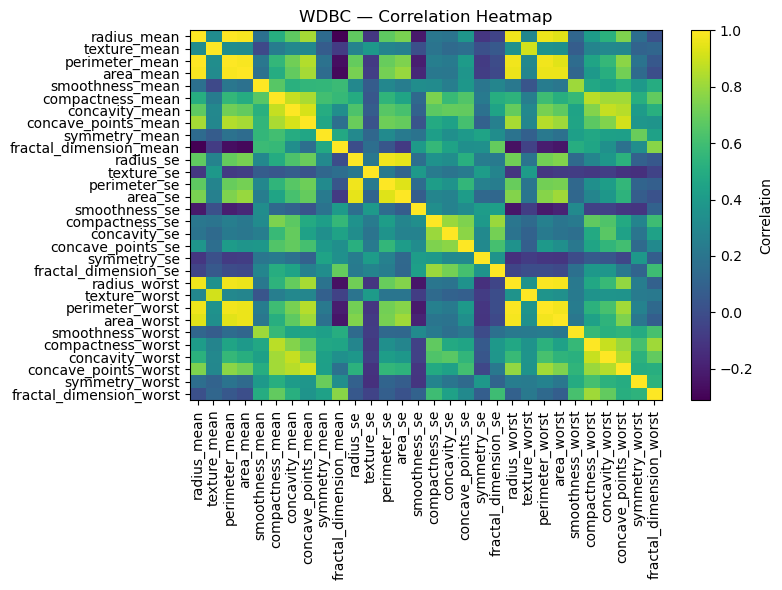

<Figure size 640x480 with 0 Axes>

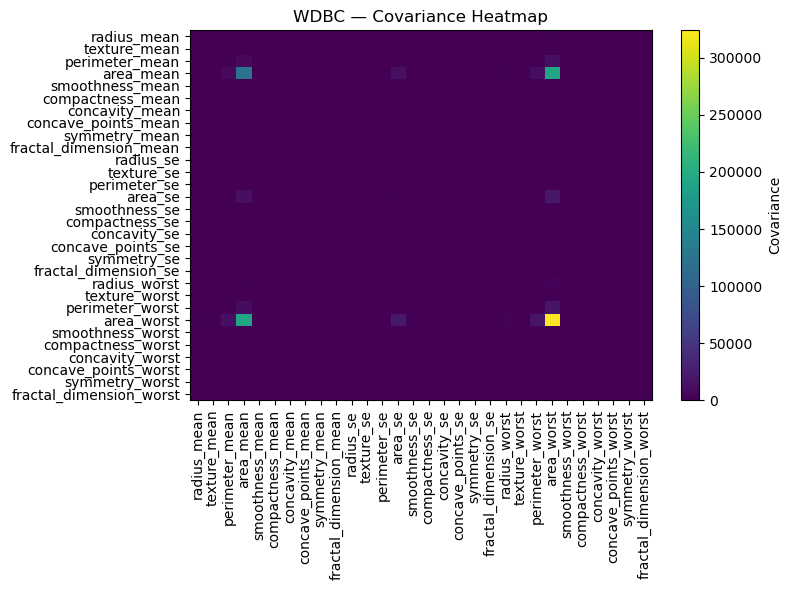

<Figure size 640x480 with 0 Axes>

In [4]:
## step2: Covariance and Correlation (WDBC)


# use X_bc_raw from step1
cov_wdbc = X_bc_raw.cov()
corr_wdbc = X_bc_raw.corr()

print("# covariance shape:", cov_wdbc.shape)
print("# correlation shape:", corr_wdbc.shape)
print("\n# correlation (first 5x5):")
print(corr_wdbc.iloc[:5, :5])

# correlation heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr_wdbc.values, aspect="auto", interpolation="nearest")
plt.title("WDBC — Correlation Heatmap")
plt.colorbar(label="Correlation")
plt.xticks(np.arange(corr_wdbc.shape[1]), corr_wdbc.columns, rotation=90)
plt.yticks(np.arange(corr_wdbc.shape[0]), corr_wdbc.index)
plt.tight_layout()
plt.show()
plt.savefig(out_dir / "wdbc_corr_heatmap.png", dpi=150)


# covariance heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cov_wdbc.values, aspect="auto", interpolation="nearest")
plt.title("WDBC — Covariance Heatmap")
plt.colorbar(label="Covariance")
plt.xticks(np.arange(cov_wdbc.shape[1]), cov_wdbc.columns, rotation=90)
plt.yticks(np.arange(cov_wdbc.shape[0]), cov_wdbc.index)
plt.tight_layout()
plt.show()
plt.savefig(out_dir / "wdbc_cov_heatmap.png", dpi=150)



In [5]:
# compute correlation (full feature set)
corr_wdbc = X_bc_raw.corr()

# take upper triangle only (no duplicates, no self-pairs)
upper_mask = np.triu(np.ones(corr_wdbc.shape, dtype=bool), k=1)
corr_pairs_wdbc = (
    corr_wdbc.where(upper_mask)
             .stack()
             .reset_index()
             .rename(columns={"level_0": "feature_i", "level_1": "feature_j", 0: "corr"})
)

# filter by absolute threshold
threshold = 0.7
high_corr_wdbc = corr_pairs_wdbc[ corr_pairs_wdbc["corr"].abs() >= threshold ] \
                    .sort_values(by="corr", key=lambda s: s.abs(), ascending=False) \
                    .reset_index(drop=True)

print(f"# total feature pairs (WDBC): {corr_pairs_wdbc.shape[0]}")
print(f"# pairs with |r| >= {threshold}: {high_corr_wdbc.shape[0]}")
print("\n# top 20 pairs by |r|:")
print(high_corr_wdbc.head(20))

# keep for later use
high_corr_pairs_wdbc = high_corr_wdbc.copy()

# total feature pairs (WDBC): 435
# pairs with |r| >= 0.7: 70

# top 20 pairs by |r|:
          feature_i            feature_j      corr
0       radius_mean       perimeter_mean  0.997855
1      radius_worst      perimeter_worst  0.993708
2       radius_mean            area_mean  0.987357
3    perimeter_mean            area_mean  0.986507
4      radius_worst           area_worst  0.984015
5   perimeter_worst           area_worst  0.977578
6         radius_se         perimeter_se  0.972794
7    perimeter_mean      perimeter_worst  0.970387
8       radius_mean         radius_worst  0.969539
9    perimeter_mean         radius_worst  0.969476
10      radius_mean      perimeter_worst  0.965137
11        area_mean         radius_worst  0.962746
12        area_mean           area_worst  0.959213
13        area_mean      perimeter_worst  0.959120
14        radius_se              area_se  0.951830
15   perimeter_mean           area_worst  0.941550
16      radius_mean           area_worst  0.941

## step3: Feature extraction (WDBC — PCA, ICA, SVD)

In [6]:
## step3.1: matrix preview (WDBC)

# use standardized features from step1
X_std = X_bc_scaled.values

# PCA (full, to preview matrices)
pca_full = PCA(n_components=None, svd_solver="full", random_state=42)
pca_full.fit(X_std)

print("# PCA matrices (WDBC)")
print("components_.shape:", pca_full.components_.shape)       # (n_components, n_features)
print("singular_values_.shape:", pca_full.singular_values_.shape)
print("explained_variance_ratio_.shape:", pca_full.explained_variance_ratio_.shape)

# Explicit SVD to preview U,S,VT shapes
U, S, VT = np.linalg.svd(X_std, full_matrices=False)  # X = U S VT
print("\n# SVD shapes (WDBC)")
print("U.shape:", U.shape)     # (n_samples, r)
print("S.shape:", S.shape)     # (r,)
print("VT.shape:", VT.shape)   # (r, n_features)


# PCA matrices (WDBC)
components_.shape: (30, 30)
singular_values_.shape: (30,)
explained_variance_ratio_.shape: (30,)

# SVD shapes (WDBC)
U.shape: (569, 30)
S.shape: (30,)
VT.shape: (30, 30)


Explained variance ratio (first 10): [0.4427 0.1897 0.0939 0.066  0.055  0.0402 0.0225 0.0159 0.0139 0.0117]
Cumulative explained variance (first 10): [0.4427 0.6324 0.7264 0.7924 0.8473 0.8876 0.9101 0.926  0.9399 0.9516]
Chosen number of components (k) for target 95%: 10


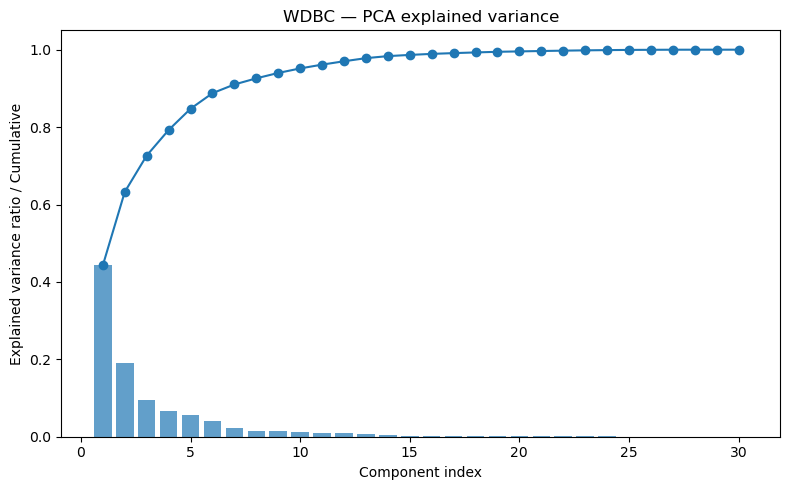

<Figure size 640x480 with 0 Axes>

In [7]:
## step3.2: PCA choose k by EVR (WDBC)

evr_target = 0.95  # you can switch to 0.90 or 0.99 if needed

pca_full = PCA(n_components=None, svd_solver="full", random_state=42)
pca_full.fit(X_std)

evr = pca_full.explained_variance_ratio_
evr_cum = np.cumsum(evr)
k = int(np.searchsorted(evr_cum, evr_target) + 1)

print("Explained variance ratio (first 10):", np.round(evr[:10], 4))
print("Cumulative explained variance (first 10):", np.round(evr_cum[:10], 4))
print(f"Chosen number of components (k) for target {evr_target*100:.0f}%:", k)

# plot + save

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(evr)+1), evr, alpha=0.7)
plt.plot(range(1, len(evr)+1), evr_cum, marker="o")
plt.xlabel("Component index")
plt.ylabel("Explained variance ratio / Cumulative")
plt.title("WDBC — PCA explained variance")
plt.tight_layout()
plt.show()
plt.savefig(out_dir / "wdbc_pca_explained_variance.png", dpi=150)


# keep k for next step
k_wdbc = k


In [8]:
## step3.3: build new features (WDBC)

# PCA projection
pca_wdbc = PCA(n_components=k_wdbc, svd_solver="full", random_state=42)
X_wdbc_pca = pca_wdbc.fit_transform(X_std)
X_bc_pca = pd.DataFrame(X_wdbc_pca, columns=[f"pc{i+1}" for i in range(k_wdbc)])

# ICA with same k
ica_wdbc = FastICA(n_components=k_wdbc, whiten="unit-variance", random_state=42, max_iter=1000)
X_wdbc_ica = ica_wdbc.fit_transform(X_std)
X_bc_ica = pd.DataFrame(X_wdbc_ica, columns=[f"ic{i+1}" for i in range(k_wdbc)])

# SVD projection to top-k right singular vectors
U, S, VT = np.linalg.svd(X_std, full_matrices=False)
V_k = VT[:k_wdbc, :].T
X_wdbc_svd = X_std @ V_k
X_bc_svd = pd.DataFrame(X_wdbc_svd, columns=[f"svd{i+1}" for i in range(k_wdbc)])

print("# shapes (WDBC):")
print("X_bc_pca:", X_bc_pca.shape, "X_bc_ica:", X_bc_ica.shape, "X_bc_svd:", X_bc_svd.shape)

# keep models for later use
pca_bc_model = pca_wdbc
ica_bc_model = ica_wdbc


# shapes (WDBC):
X_bc_pca: (569, 10) X_bc_ica: (569, 10) X_bc_svd: (569, 10)


## Step 4: Feature Selection (SelectKBest + RFE)

In [9]:
# step4.1: SelectKBest 

from sklearn.feature_selection import SelectKBest, f_classif

X_bc = X_bc_raw        
y_bc = y_bc_target       

k_bc = 10                # choose top-10 (aligned with PCA k=10)

selector_bc = SelectKBest(score_func=f_classif, k=k_bc)
X_bc_kbest = selector_bc.fit_transform(X_bc, y_bc)

selected_features_bc = X_bc.columns[selector_bc.get_support()]
print("# Selected features (WDBC - KBest):", list(selected_features_bc))
print("Shape:", X_bc_kbest.shape)


# Selected features (WDBC - KBest): ['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave_points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst', 'concave_points_worst']
Shape: (569, 10)


In [10]:
# step4.2: RFE

logreg_bc = LogisticRegression(max_iter=5000, solver="liblinear")
rfe_bc = RFE(estimator=logreg_bc, n_features_to_select=k_bc)

X_bc_rfe = rfe_bc.fit_transform(X_bc, y_bc)
selected_rfe_bc = X_bc.columns[rfe_bc.get_support()]
print("# Selected features (WDBC - RFE):", list(selected_rfe_bc))
print("Shape:", X_bc_rfe.shape)


# Selected features (WDBC - RFE): ['radius_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'radius_worst', 'smoothness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Shape: (569, 10)


## step5: KNN,RandomForest — original vs PCA vs RFE

In [11]:

## step5A: KNN on original / PCA / RFE (WDBC)

# -- unify inputs to numpy arrays
X_orig = np.asarray(X_bc)                 # (n, 30)
X_pca  = np.asarray(X_bc_pca)             # (n, k) built from standardized X
X_rfe  = np.asarray(X_bc_rfe)             # (n, 10)
y      = np.asarray(y_bc)                 # (n,)

# -- single split for fair comparison
idx = np.arange(len(y))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)

def run_knn(X, do_scale, name):
    # split
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    # optional scaling
    if do_scale:
        sc = StandardScaler()
        X_tr = sc.fit_transform(X_tr)
        X_te = sc.transform(X_te)

    # fit & predict timing
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_tr, y_tr)

    t0 = time.perf_counter()
    y_pred = clf.predict(X_te)
    pred_t = time.perf_counter() - t0

    acc = accuracy_score(y_te, y_pred)
    print(f"[KNN] {name:>8} | acc: {acc:.4f} | pred_time(s): {pred_t:.6f}")

# -- runs
run_knn(X_orig, True,  "original")  # original needs scaling
run_knn(X_pca,  False, "PCA")       # PCA already from standardized X
run_knn(X_rfe,  True,  "RFE")       # scale RFE subset for fair distance metric

[KNN] original | acc: 0.9561 | pred_time(s): 0.052719
[KNN]      PCA | acc: 0.9561 | pred_time(s): 0.011949
[KNN]      RFE | acc: 0.9211 | pred_time(s): 0.011940


In [12]:
## step5B: RandomForest on original / PCA / RFE (WDBC)

def run_rf(X, name):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_tr)

    t0 = time.perf_counter()
    y_pred = clf.predict(X_te)
    pred_t = time.perf_counter() - t0

    acc = accuracy_score(y_te, y_pred)
    print(f"[RF ] {name:>8} | acc: {acc:.4f} | pred_time(s): {pred_t:.6f}")

# -- runs
run_rf(X_orig, "original")
run_rf(X_pca,  "PCA")
run_rf(X_rfe,  "RFE")


[RF ] original | acc: 0.9737 | pred_time(s): 0.374334
[RF ]      PCA | acc: 0.9474 | pred_time(s): 0.075328
[RF ]      RFE | acc: 0.9474 | pred_time(s): 0.073379


## Step 6: summarize & compare

In [13]:
## step6A: summarize classification results (WDBC)

# -- expect these from earlier steps
# X_bc (n,30), X_bc_pca (n,k), X_bc_rfe (n,10), y_bc (n,)
if not all(name in globals() for name in ["X_bc","X_bc_pca","X_bc_rfe","y_bc"]):
    raise NameError("Missing one of: X_bc, X_bc_pca, X_bc_rfe, y_bc. Run Steps 1–5 for classification.")

X_orig = np.asarray(X_bc)
X_pca  = np.asarray(X_bc_pca)
X_rfe  = np.asarray(X_bc_rfe)
y      = np.asarray(y_bc)

# -- one stratified split for fair comparison
idx = np.arange(len(y))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)

def eval_knn(X, name, scale_before):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    if scale_before:
        sc = StandardScaler()
        X_tr = sc.fit_transform(X_tr)
        X_te = sc.transform(X_te)
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_tr, y_tr)
    t0 = time.perf_counter()
    y_pred = clf.predict(X_te)
    pred_t = time.perf_counter() - t0
    acc = accuracy_score(y_te, y_pred)
    return {"model":"KNN","space":name,"acc":acc,"pred_time":pred_t}

def eval_rf(X, name):
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_tr)
    t0 = time.perf_counter()
    y_pred = clf.predict(X_te)
    pred_t = time.perf_counter() - t0
    acc = accuracy_score(y_te, y_pred)
    return {"model":"RF","space":name,"acc":acc,"pred_time":pred_t}

# -- run all
rows = []
rows.append(eval_knn(X_orig, "original", True))
rows.append(eval_knn(X_pca,  "PCA",      False))
rows.append(eval_knn(X_rfe,  "RFE",      True))
rows.append(eval_rf (X_orig, "original"))
rows.append(eval_rf (X_pca,  "PCA"))
rows.append(eval_rf (X_rfe,  "RFE"))

df_cls = pd.DataFrame(rows)

# -- compute deltas vs original per model
def add_deltas(df):
    out = []
    for m in df["model"].unique():
        base = df[(df["model"]==m) & (df["space"]=="original")].iloc[0]
        for _, r in df[df["model"]==m].iterrows():
            out.append({
                "model": m,
                "space": r["space"],
                "acc": r["acc"],
                "pred_time": r["pred_time"],
                "Δacc_vs_orig": r["acc"] - base["acc"],
                "speedup_vs_orig": (base["pred_time"] / r["pred_time"]) if r["pred_time"]>0 else np.nan
            })
    return pd.DataFrame(out)

df_cls_summary = add_deltas(df_cls)

print("# classification summary (WDBC)")
print(df_cls_summary.to_string(index=False))


# classification summary (WDBC)
model    space      acc  pred_time  Δacc_vs_orig  speedup_vs_orig
  KNN original 0.956140   0.002903      0.000000         1.000000
  KNN      PCA 0.956140   0.016298      0.000000         0.178113
  KNN      RFE 0.921053   0.021744     -0.035088         0.133505
   RF original 0.973684   0.077475      0.000000         1.000000
   RF      PCA 0.947368   0.088351     -0.026316         0.876903
   RF      RFE 0.947368   0.075502     -0.026316         1.026130


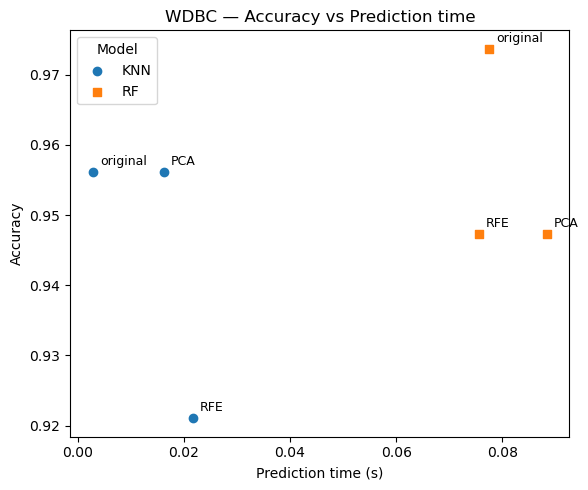

Saved: ../outputs/figures/wdbc_accuracy_vs_predtime_scatter.png


In [ ]:
# ensure output dir
out_dir = Path("../outputs/figures")
out_dir.mkdir(parents=True, exist_ok=True)

# enforce consistent order
space_order = ["original", "PCA", "RFE"]
model_order = ["KNN", "RF"]

dfp = df_cls.copy()
dfp["space"] = pd.Categorical(dfp["space"], categories=space_order, ordered=True)
dfp["model"] = pd.Categorical(dfp["model"], categories=model_order, ordered=True)
dfp = dfp.sort_values(["model", "space"])

dfs = df_cls_summary.copy()
dfs["space"] = pd.Categorical(dfs["space"], categories=space_order, ordered=True)
dfs["model"] = pd.Categorical(dfs["model"], categories=model_order, ordered=True)
dfs = dfs.sort_values(["model", "space"])

# save tables too (optional)
dfp.to_csv(out_dir.parent / "wdbc_cls_raw.csv", index=False)
dfs.to_csv(out_dir.parent / "wdbc_cls_summary.csv", index=False)


#Joint view: accuracy vs pred_time scatter
plt.figure(figsize=(6,5))
markers = {"KNN":"o", "RF":"s"}
for m in model_order:
    dsub = dfp[dfp["model"] == m]
    plt.scatter(dsub["pred_time"].values, dsub["acc"].values, marker=markers[m], label=m)
    # annotate points with space
    for (_, r) in dsub.iterrows():
        plt.annotate(r["space"], (r["pred_time"], r["acc"]), xytext=(5,5), textcoords="offset points", fontsize=9)
plt.xlabel("Prediction time (s)")
plt.ylabel("Accuracy")
plt.title("WDBC — Accuracy vs Prediction time")
plt.legend(title="Model")
plt.tight_layout()
fname = out_dir / "wdbc_accuracy_vs_predtime_scatter.png"
plt.savefig(fname, dpi=150)
plt.show()
print(f"Saved: {fname}")